# Pystan implementation of hierarchical model 

In [1]:
import sys
import numpy as np
import pystan
import pandas as pd
import scipy.stats
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

Generate the fake data

In [2]:
# Define the constants. 
n_div = 100 
n_tot = np.random.gamma(10, 20, size=n_div).astype(int)
n1 = np.random.binomial(n_tot, p=0.5)
n2 = n_tot - n1

# Convert to intensity. 
alpha = 200
I1 = n1 * alpha #+ np.random.normal(loc=alpha, scale=50)
I2 = n2 * alpha #+ np.random.normal(loc=alpha, scale=50)

# Compute the squared difference adn summed intensity
summed = I1 + I2 
sq_diff = (I1 - I2)**2
summed_range = np.logspace(4, 5, 500)

# Assemble as a dataframe.
data = pd.DataFrame(np.array([I1, I2, summed, sq_diff]).T, 
                   columns=['I1', 'I2', 'summed', 'sq_diff'])

# Compute the fit. 
ground_truth = pd.DataFrame(np.array([summed_range, alpha * summed_range]).T,
                           columns=['summed_range', 'theo'])

Generate the plot 

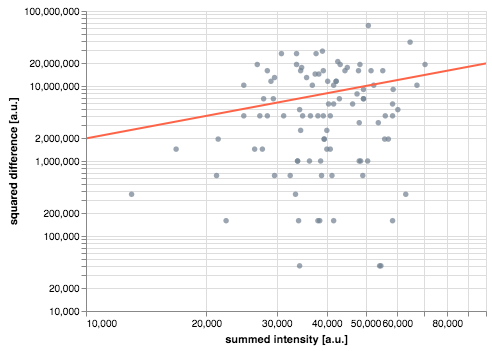

In [3]:
points = alt.Chart(data[data['sq_diff'] != 0]).mark_circle(color='slategray').encode(
    x=alt.X('summed', title='summed intensity [a.u.]', scale={'type':'log'}),
    y=alt.Y('sq_diff', title='squared difference [a.u.]', scale={'type':'log'}),
    )

fit = alt.Chart(ground_truth).mark_line(color='tomato').encode(
    x=alt.X('summed_range', title='summed intensity [a.u.]', scale={'type':'log'}),
    y=alt.Y('theo', title='squared difference [a.u.]', scale={'type':'log'}))

(points + fit).interactive()

Define a pystan model assuming a gaussian approximation of binomial

In [29]:
model_code = """
functions{
    // Define a custom function for a marginalized Homoscedasitc normal. 
    real MarginalizedNormal_lpdf(vector x, vector mu) {
    real lprob;
    vector[num_elements(x)] prob;
    int k;
    k = num_elements(x); 
    for (i in 1:k) {
        prob[i] = (x[i] - mu[i])^2;
    }
    lprob = -0.5 * k * sum(log(prob));
    return lprob;
    }
    }
data {
    int N; // Number of data points.
    vector[N] I1; 
    vector[N] I2;
    }
    
parameters {
    vector<lower=0>[N] ntot;
    vector<lower=0, upper=ntot[N]>[N] n1;
    real<lower=0> sigma;
    real<lower=0>alpha;

    }
model {
    vector[N] mu_1;
    vector[N] mu_2;
    ntot ~ normal(100, 100);
    n1 ~ normal(ntot * 0.5, ntot * 0.25);
    alpha ~ uniform(0, 500);
    sigma ~ normal(0, 10);
    
    for (i in 1:N) {
        mu_1[i] = alpha * n1[i];
        mu_2[i] = alpha * (ntot[i] - n1[i]);
    }
 
    I1 ~ normal(mu_1, sigma);
    I2 ~ normal(mu_2, sigma);
}
"""

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b92b2048f333d2dc8017282d4b185d2c NOW.


In [ ]:
# Define the data dictionary and try to sample.
data_dict = {'N':n_div, 'I1':I1, 'I2':I2}
samples = model.sampling(data=data_dict, iter=100000, chains=4, thin=100)

In [31]:
samples

Inference for Stan model: anon_model_b92b2048f333d2dc8017282d4b185d2c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
ntot[0]   72.75   12.54  17.73  58.97  61.66  63.31  87.14 105.53      2   9.51
ntot[1]   85.34    15.0  21.22  69.12  72.45   74.0 106.71 124.73      2  11.67
ntot[2]  119.28   20.84  29.47  98.78 101.49 102.96 140.43 174.06      2  14.69
ntot[3]   80.61    14.5   20.5  65.51  68.06  69.48 103.85 118.55      2   9.95
ntot[4]  108.82   19.12  27.04  89.87  92.62  94.14 128.48 158.98      2  11.18
ntot[5]   112.2   19.34  27.35  92.57  95.99  97.18 133.99 163.08      2  16.53
ntot[6]   72.01   12.97  18.35  58.52  60.97  62.53  92.86 105.53      2    5.7
ntot[7]  133.76    22.3  31.54 110.17 112.07 115.08 158.77 191.87      2  12.84
ntot[8]   72.85   13.01   18.4  59.14   61.7  63.14  88.93 106.91      2   9.93
ntot[9]  